In [ ]:
import numpy as np

# Function to read ASCII raster file
def read_asc_file(file_path):
    # Read header information
    with open(file_path, 'r') as f:
        ncols = None
        nrows = None
        xllcorner = None
        yllcorner = None
        cellsize = None
        nodata_value = None

        for line in f:
            line = line.strip().split()
            if len(line) == 2:
                if line[0].lower() == 'ncols':
                    ncols = int(line[1])
                elif line[0].lower() == 'nrows':
                    nrows = int(line[1])
                elif line[0].lower() == 'xllcorner':
                    xllcorner = float(line[1])
                elif line[0].lower() == 'yllcorner':
                    yllcorner = float(line[1])
                elif line[0].lower() == 'cellsize':
                    cellsize = float(line[1])
                elif line[0].lower() == 'nodata_value':
                    nodata_value = float(line[1])
            else:
                break

    # Read data values
    data = np.genfromtxt(file_path, skip_header=6)

    return {
        'ncols': ncols,
        'nrows': nrows,
        'xllcorner': xllcorner,
        'yllcorner': yllcorner,
        'cellsize': cellsize,
        'nodata_value': nodata_value,
        'data': data
    }


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Example usage
file_path = r""
data = read_asc_file(file_path)
print(data["data"])
print(data["data"].shape)

In [ ]:
plt.figure()
plt.imshow(data["data"])
plt.clim(0.0,0.2)
plt.colorbar()

In [ ]:
data_np = np.array(data["data"])

In [ ]:
def avg_pool(arr):
    arr = np.pad(arr, ((0, 0), (0, 1)), mode='constant')
    x, y = arr.shape
    new_x, new_y = x//2, y//2
    arr = np.mean(arr.reshape(new_x, 2, new_y, 2), axis=(1, 3))
    return arr

In [ ]:
print(avg_pool(data_np).shape)
plt.imshow(avg_pool(data_np))
plt.clim(0.0,0.2)
plt.colorbar()

In [ ]:
from dataloader import CustomDataset
import torch
from tqdm import tqdm

root_pth = r"D:\Study\AI_CFD\SWE\datasets"

dataset = CustomDataset(root_pth)
length = len(dataset)
means = 0
stds = 0
pmeans, pstds = 0, 0
for d in tqdm(range(length)):
    x, p = dataset[d]
    mean = torch.mean(x, dim=(1, 2))
    std = torch.std(x, dim=(1, 2))
    pmean = torch.mean(p)
    pstd = torch.std(p)
    pmeans += pmean
    pstds += pstd

    means += mean
    stds += std

means /= length
stds /= length
pmeans /= length
pstds /= length

print("Overall mean of each channel (depth, xvel, yvel):", means)
print("Overall standard deviation of each channel (depth, xvel, yvel):", stds)

print()
print("pmeans and pstds: ", pmeans, pstds)

In [1]:
from dataloader import CustomDataset
import numpy as np
from tqdm import tqdm

root_pth = r"D:\Study\AI_CFD\SWE\datasets"

dataset = CustomDataset(root_pth, norm=False)
length = len(dataset)
num_bins = 50
red_counts = np.zeros(num_bins)
green_counts = np.zeros(num_bins)
blue_counts = np.zeros(num_bins)
for d in tqdm(range(length)):
    x, _ = dataset[d]  # x.shape: (channel, height, width)

    # Assuming x is in the shape (3, height, width) for RGB images
    red_channel = x[0, :, :]
    green_channel = x[1, :, :]
    blue_channel = x[2, :, :]

    # Compute histogram counts for each channel
    red_hist, _ = np.histogram(red_channel, bins=num_bins, range=(0, 0.2))
    green_hist, _ = np.histogram(green_channel, bins=num_bins, range=(-0.2, 0.2))
    blue_hist, _ = np.histogram(blue_channel, bins=num_bins, range=(-0.2, 0.2))

    # Accumulate histogram counts
    red_counts += red_hist
    green_counts += green_hist
    blue_counts += blue_hist


100%|██████████| 19440/19440 [2:28:52<00:00,  2.18it/s]  


In [57]:
bin_width = 0.2 / num_bins
def anom_label(bars, cnt, val):
    for bar, value in zip(bars, cnt):
        if value > val:
            bar.set_color('red')
            plt.text(bar.get_x() + 2*bar.get_width(), val*0.95, f"{value:.2e}", ha='left', va='bottom', color="red")

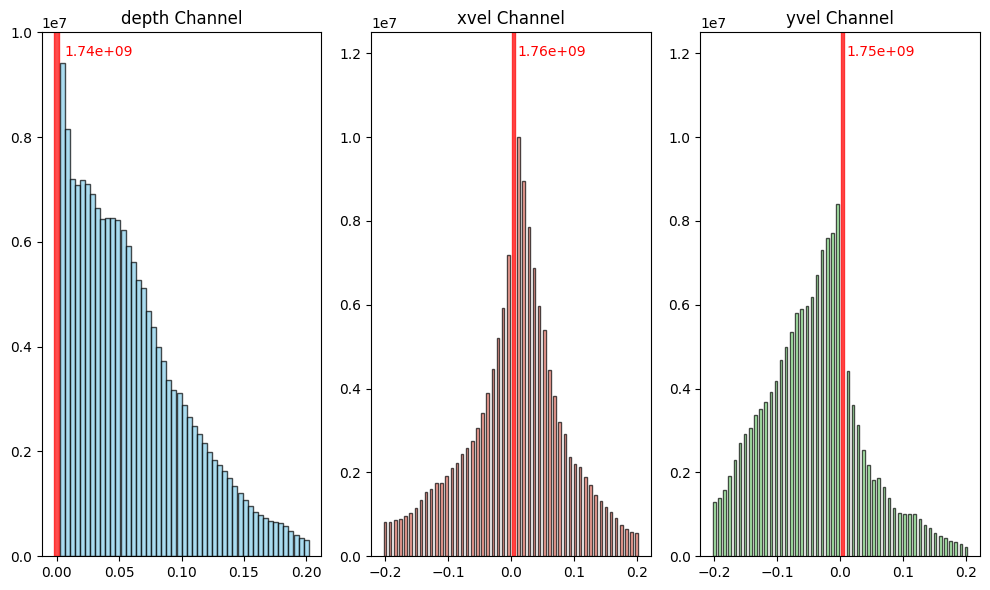

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
bars = plt.bar(np.linspace(0, 0.2, num_bins), red_counts, color='skyblue', edgecolor='black', alpha=0.7, width=bin_width)
anom_label(bars, red_counts, 1e7)
plt.ylim(0, 1e7)
plt.title('depth Channel')

plt.subplot(1, 3, 2)
bars = plt.bar(np.linspace(-0.2, 0.2, num_bins), green_counts, color='salmon', edgecolor='black', alpha=0.7, width=bin_width)
anom_label(bars, green_counts, 1.25e7)
plt.ylim(0, 1.25e7)
plt.title('xvel Channel')

plt.subplot(1, 3, 3)
bars = plt.bar(np.linspace(-0.2, 0.2, num_bins), blue_counts, color='lightgreen', edgecolor='black', alpha=0.7, width=bin_width)
anom_label(bars, blue_counts, 1.25e7)
plt.ylim(0, 1.25e7)
plt.title('yvel Channel')

plt.tight_layout()
plt.show()

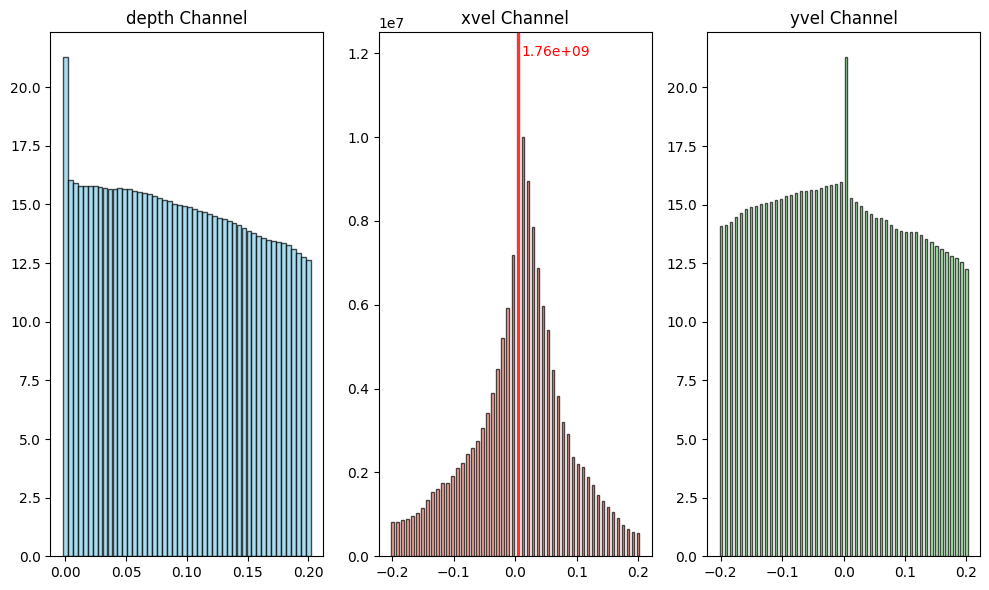

In [74]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
bars = plt.bar(np.linspace(0, 0.2, num_bins), np.log1p(red_counts), color='skyblue', edgecolor='black', alpha=0.7, width=bin_width)
# anom_label(bars, red_counts, 1e7)
# plt.ylim(0, 1e7)
plt.title('depth Channel')

plt.subplot(1, 3, 2)
bars = plt.bar(np.linspace(-0.2, 0.2, num_bins), green_counts, color='salmon', edgecolor='black', alpha=0.7, width=bin_width)
anom_label(bars, green_counts, 1.25e7)
plt.ylim(0, 1.25e7)
plt.title('xvel Channel')

plt.subplot(1, 3, 3)
bars = plt.bar(np.linspace(-0.2, 0.2, num_bins), np.log1p(blue_counts), color='lightgreen', edgecolor='black', alpha=0.7, width=bin_width)
# anom_label(bars, blue_counts, 1.25e7)
# plt.ylim(0, 1.25e7)
plt.title('yvel Channel')

plt.tight_layout()
plt.show()

(0.0, 5000.0)

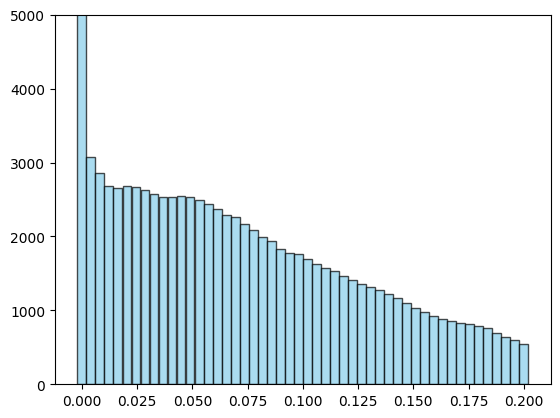

In [71]:
bin_width = 0.2 / num_bins
bars = plt.bar(np.linspace(0, 0.2, num_bins), np.sqrt(red_counts), color='skyblue', edgecolor='black', alpha=0.7, width=bin_width)
plt.ylim(0, 5000)

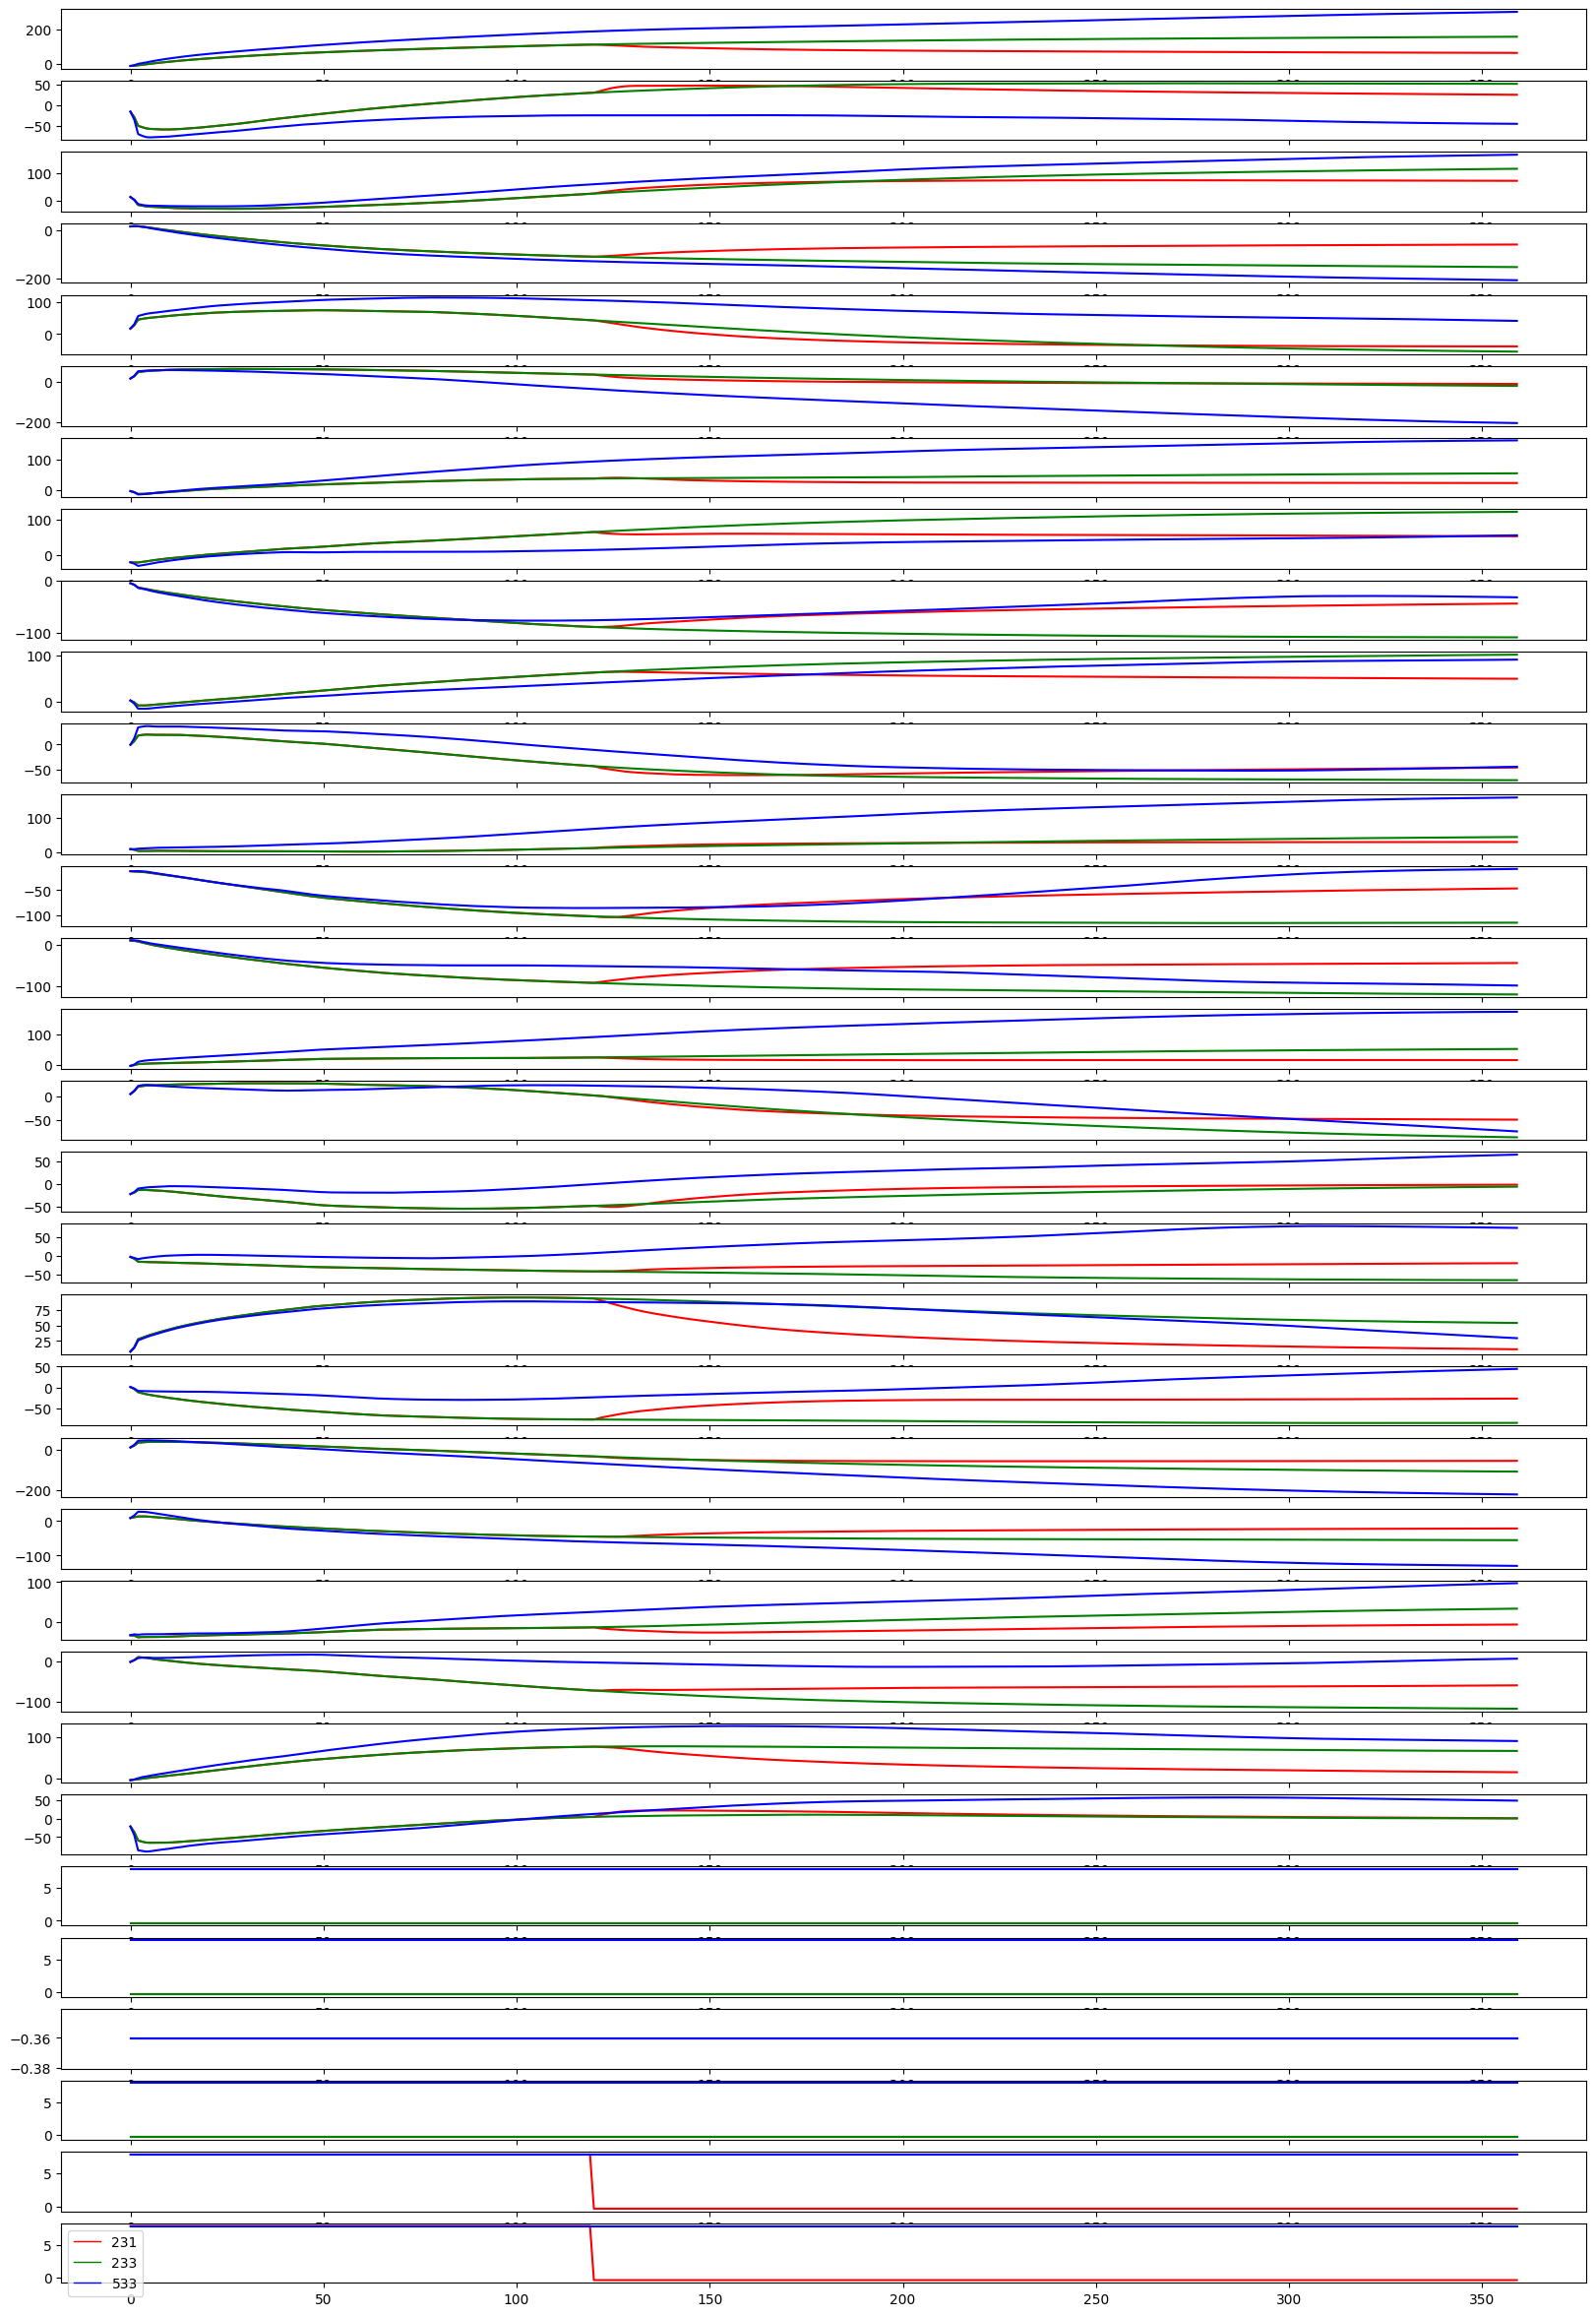

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], lw=1, color='r', label='231'),
                   Line2D([0], [0], lw=1, color='g', label='233'),
                   Line2D([0], [0], lw=1, color='b', label='533'),]

d533 = r"D:\Study\AI_CFD\SWE\datasets\linear\533.npy"
d233 = r"D:\Study\AI_CFD\SWE\datasets\linear\233.npy"
d231 = r"D:\Study\AI_CFD\SWE\datasets\linear\231.npy"

data533 = np.load(d533)
data233 = np.load(d233)
data231 = np.load(d231)

i= 1
plt.figure(figsize=(20, 30))
for group in range(32):
    plt.subplot(32, 1, i)
    plt.plot(data231[:, group], color="r")
    plt.plot(data233[:, group], color="g")
    plt.plot(data533[:, group], color='b')
    i += 1

plt.legend(handles=legend_elements, loc='best')
plt.show()